# Assignment 5
## Group Members:
### Nils Dunlop, e-mail: gusdunlni@student.gu.se
### Francisco Alejandro Erazo Piza, e-mail: guserafr@student.gu.se
### Chukwudumebi Ubogu, e-mail: gusuboch@student.gu.se
***

### Preliminaries
***

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Mar  6 10:19:23 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0              23W / 300W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [3]:
# Importing libraries
# Basic file and operating system operations
import os
from pathlib import Path

# PyTorch for model building and training
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset

# torchvision for datasets, models, and transforms
import torchvision
from torchvision import datasets, models, transforms
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18, resnet50, resnet101, ResNet18_Weights, ResNet50_Weights, ResNet101_Weights

# For image manipulation and visualization
from PIL import Image
import matplotlib.pyplot as plt

# For data handling and timestamp
import pandas as pd
import datetime

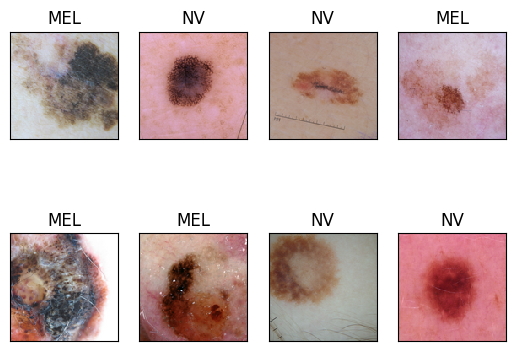

In [4]:
folder = ImageFolder('/content/drive/MyDrive/Colab Notebooks/a5_data/train', transform=torchvision.transforms.ToTensor())
loader = DataLoader(folder, batch_size=8, shuffle=True)

Xexamples, Yexamples = next(iter(loader))

for i in range(8):
    plt.subplot(2,4,i+1)
    img = Xexamples[i].numpy().transpose(1, 2, 0)
    plt.imshow(img, interpolation='none')
    plt.title('NV' if Yexamples[i] else 'MEL')
    plt.xticks([])
    plt.yticks([])

### Apply the these techniques:
- some sort of normalization such as batch normalization, layer normalization, or group normalization,
- residual connections,
- data augmentation by applying random transformations to the images,
- transfer learning using a pre-trained model (see below for some hints).

### Exploring the efficiency of ResNET50, ResNET18 and ResNET101 on detecting skin cancer

### Task 1: Preprocessing
***

In [5]:
def count_files(path):
    return sum([len(files) for r, d, files in os.walk(path)])


# Paths for MEL and NV
train_path_MEL= '/content/drive/MyDrive/Colab Notebooks/a5_data/train/MEL'
train_path_NV= '/content/drive/MyDrive/Colab Notebooks/a5_data/train/NV'

val_path_MEL= '/content/drive/MyDrive/Colab Notebooks/a5_data/val/MEL'
val_path_NV= '/content/drive/MyDrive/Colab Notebooks/a5_data/val/NV'

test_blind_path = '/content/drive/MyDrive/Colab Notebooks/a5_data/test_blind/blind'

# Paths to train and val
train_path = '/content/drive/MyDrive/Colab Notebooks/a5_data/train'
val_path = '/content/drive/MyDrive/Colab Notebooks/a5_data/val'

print('**training set**')
print('MEL:', count_files(train_path_MEL))
print('NV:', count_files(train_path_NV))

print('**validation set**')
print('MEL:', count_files(val_path_MEL))
print('NV:', count_files(val_path_NV))

print('**test set**')
print('TOTAL:', count_files(test_blind_path))

**training set**
MEL: 3213
NV: 3213
**validation set**
MEL: 626
NV: 626
**test set**
TOTAL: 1366


In [6]:
def calculate_average_image_dimensions(folder_path):
    # List of common image extensions
    image_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp']

    # Initialize variables to store total width, total height, and count of images
    total_width = 0
    total_height = 0
    image_count = 0

    # Iterate through each file in the folder
    for file in os.listdir(folder_path):
        if Path(file).suffix.lower() in image_extensions:
            try:
                # Open the image and get its dimensions
                file_path = os.path.join(folder_path, file)
                with Image.open(file_path) as img:
                    width, height = img.size
                    total_width += width
                    total_height += height
                    image_count += 1
            except Exception as e:
                print(f"Error processing {file}: {e}")

    # Calculate the average dimensions
    average_width = total_width / image_count if image_count else 0
    average_height = total_height / image_count if image_count else 0

    return average_width, average_height


print('Average dimensions of training images with melenoma:', calculate_average_image_dimensions(train_path_MEL))
print('Average dimensions of training images without melenoma:', calculate_average_image_dimensions(train_path_NV))

Average dimensions of training images with melenoma: (128.0, 128.0)
Average dimensions of training images without melenoma: (128.0, 128.0)


In [7]:
torch.manual_seed(42)

# Define transformations for the training data and validation data
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
    transforms.RandomRotation(10),  # Randomly rotate images by up to 10 degrees
    # Add ColorJitter for brightness, contrast, saturation, and hue adjustments
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalize images
                         std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224 for validation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalize images
                         std=[0.229, 0.224, 0.225])
])

# Load datasets
train_folder = ImageFolder(train_path, transform=train_transforms)
val_folder = ImageFolder(val_path, transform=val_transforms)

# Create data loaders
train_loader = DataLoader(train_folder, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_folder, batch_size=32, shuffle=False, num_workers=2)

In [8]:
print("Training dataset classes and their indices:", train_folder.class_to_idx)
print("Validation dataset classes and their indices:", val_folder.class_to_idx)

Training dataset classes and their indices: {'MEL': 0, 'NV': 1}
Validation dataset classes and their indices: {'MEL': 0, 'NV': 1}


In [9]:
def load_pretrained_resnet(model_name):
    if model_name == 'resnet18':
        model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
    elif model_name == 'resnet50':
        model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
    elif model_name == 'resnet101':
        model = models.resnet101(weights=ResNet101_Weights.IMAGENET1K_V1)
    else:
        raise ValueError(f"Unsupported model name: {model_name}")

    # Replace the final fully connected layer for binary classification
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 2)

    return model

In [10]:
def configure_model_for_training(model_name, device, unfreeze_layers=True):
    # Load the specified ResNet model pre-trained weights
    model = load_pretrained_resnet(model_name)

    # Unfreeze the last layers based on parameter
    if unfreeze_layers:
        for param in model.layer4.parameters():
            param.requires_grad = True
        for param in model.layer3.parameters():
            param.requires_grad = True

    # Move the model to the specified device (CPU/GPU)
    model.to(device)

    # Setup the optimizer with specific learning rates for unfrozen layers
    optimizer = optim.SGD([
        {'params': model.layer4.parameters(), 'lr': 1e-4, 'momentum': 0.9},
        {'params': model.layer3.parameters(), 'lr': 1e-4, 'momentum': 0.9},
        {'params': model.fc.parameters(), 'lr': 1e-3, 'momentum': 0.9}
    ], lr=1e-4, momentum=0.9)

    # Define the loss criterion
    criterion = torch.nn.CrossEntropyLoss()

    # Define the learning rate scheduler
    scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

    return model, optimizer, criterion, scheduler

In [11]:
def train_model_with_early_stopping(model, criterion, optimizer, scheduler, train_loader, val_loader, device, epochs=25, patience=5):
    best_val_loss = float('inf')
    best_model_wts = model.state_dict()  # Ensure we have a copy of the best model weights
    patience_counter = 0

    epoch_loss_history = []
    epoch_acc_history = []
    val_loss_history = []
    val_acc_history = []

    for epoch in range(epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        running_corrects = 0

        # Training phase
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()  # Zero the parameter gradients

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            loss.backward()  # Backward pass
            optimizer.step()  # Optimize

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)

        epoch_loss_history.append(epoch_loss)
        epoch_acc_history.append(epoch_acc.item())

        # Validation phase
        model.eval()  # Set model to evaluate mode
        val_loss = 0.0
        val_corrects = 0

        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels.data)

        val_loss = val_loss / len(val_loader.dataset)
        val_acc = val_corrects.double() / len(val_loader.dataset)

        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc.item())

        print(f'Epoch {epoch}/{epochs - 1} - Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

        # Adjust the learning rate based on the scheduler
        scheduler.step()

        # Check for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_wts = model.state_dict()  # Update the best model weights
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'Stopping early at epoch {epoch} due to no improvement in validation loss.')
                break

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, epoch_loss_history, epoch_acc_history, val_loss_history, val_acc_history

In [12]:
def setup_and_train_model(model_name, train_loader, val_loader, device='cuda', epochs=25, patience=5, save_model=True):
    # Configure the model for training
    model, optimizer, criterion, scheduler = configure_model_for_training(model_name, device)

    # Train the model
    model_trained, train_loss_hist, train_acc_hist, val_loss_hist, val_acc_hist = train_model_with_early_stopping(
        model, criterion, optimizer, scheduler, train_loader, val_loader, device, epochs, patience
    )

    # Save the trained model
    if save_model:
        # Format the current date and time
        now = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        save_path = f'/content/drive/MyDrive/Colab Notebooks/{model_name}_classification_model_{now}.pth'
        torch.save(model_trained.state_dict(), save_path)
        print(f"Model saved to {save_path}")

    return model_trained

In [13]:
# List of ResNet models to train
resnet_models = ['resnet18', 'resnet50', 'resnet101']

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Iterate over the list of ResNet models and train each
for model_name in resnet_models:
    print(f"Starting training for {model_name}")
    trained_model = setup_and_train_model(model_name, train_loader, val_loader, device=device, epochs=25, patience=5, save_model=True)
    print(f"Training completed for {model_name}")

Starting training for resnet18


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 182MB/s]


Epoch 0/24 - Loss: 0.4509, Acc: 0.7714, Val Loss: 0.3690, Val Acc: 0.8315
Epoch 1/24 - Loss: 0.3872, Acc: 0.8198, Val Loss: 0.3906, Val Acc: 0.8099
Epoch 2/24 - Loss: 0.3610, Acc: 0.8294, Val Loss: 0.3294, Val Acc: 0.8530
Epoch 3/24 - Loss: 0.3527, Acc: 0.8374, Val Loss: 0.3264, Val Acc: 0.8570
Epoch 4/24 - Loss: 0.3442, Acc: 0.8466, Val Loss: 0.3396, Val Acc: 0.8411
Epoch 5/24 - Loss: 0.3453, Acc: 0.8447, Val Loss: 0.3142, Val Acc: 0.8530
Epoch 6/24 - Loss: 0.3291, Acc: 0.8525, Val Loss: 0.3020, Val Acc: 0.8626
Epoch 7/24 - Loss: 0.3193, Acc: 0.8599, Val Loss: 0.2977, Val Acc: 0.8674
Epoch 8/24 - Loss: 0.3271, Acc: 0.8545, Val Loss: 0.2950, Val Acc: 0.8642
Epoch 9/24 - Loss: 0.3219, Acc: 0.8531, Val Loss: 0.2967, Val Acc: 0.8690
Epoch 10/24 - Loss: 0.3085, Acc: 0.8620, Val Loss: 0.2939, Val Acc: 0.8682
Epoch 11/24 - Loss: 0.3065, Acc: 0.8627, Val Loss: 0.2936, Val Acc: 0.8634
Epoch 12/24 - Loss: 0.2980, Acc: 0.8680, Val Loss: 0.2934, Val Acc: 0.8666
Epoch 13/24 - Loss: 0.3027, Acc: 0.

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 188MB/s]


Epoch 0/24 - Loss: 0.4448, Acc: 0.7789, Val Loss: 0.3553, Val Acc: 0.8395
Epoch 1/24 - Loss: 0.3670, Acc: 0.8316, Val Loss: 0.3216, Val Acc: 0.8522
Epoch 2/24 - Loss: 0.3506, Acc: 0.8399, Val Loss: 0.3910, Val Acc: 0.8395
Epoch 3/24 - Loss: 0.3373, Acc: 0.8461, Val Loss: 0.2967, Val Acc: 0.8570
Epoch 4/24 - Loss: 0.3215, Acc: 0.8564, Val Loss: 0.2980, Val Acc: 0.8634
Epoch 5/24 - Loss: 0.3095, Acc: 0.8603, Val Loss: 0.3026, Val Acc: 0.8546
Epoch 6/24 - Loss: 0.3028, Acc: 0.8641, Val Loss: 0.3578, Val Acc: 0.8514
Epoch 7/24 - Loss: 0.3004, Acc: 0.8687, Val Loss: 0.3082, Val Acc: 0.8714
Epoch 8/24 - Loss: 0.2907, Acc: 0.8743, Val Loss: 0.3242, Val Acc: 0.8666
Stopping early at epoch 8 due to no improvement in validation loss.
Model saved to /content/drive/MyDrive/Colab Notebooks/resnet50_classification_model_2024-03-06_10-50-34.pth
Training completed for resnet50
Starting training for resnet101


Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:01<00:00, 176MB/s]


Epoch 0/24 - Loss: 0.4317, Acc: 0.7865, Val Loss: 0.3828, Val Acc: 0.8323
Epoch 1/24 - Loss: 0.3614, Acc: 0.8364, Val Loss: 0.3455, Val Acc: 0.8506
Epoch 2/24 - Loss: 0.3399, Acc: 0.8455, Val Loss: 0.3050, Val Acc: 0.8634
Epoch 3/24 - Loss: 0.3246, Acc: 0.8491, Val Loss: 0.3114, Val Acc: 0.8618
Epoch 4/24 - Loss: 0.3105, Acc: 0.8593, Val Loss: 0.2846, Val Acc: 0.8746
Epoch 5/24 - Loss: 0.3023, Acc: 0.8676, Val Loss: 0.2839, Val Acc: 0.8706
Epoch 6/24 - Loss: 0.2975, Acc: 0.8659, Val Loss: 0.2764, Val Acc: 0.8778
Epoch 7/24 - Loss: 0.2876, Acc: 0.8722, Val Loss: 0.2873, Val Acc: 0.8690
Epoch 8/24 - Loss: 0.2739, Acc: 0.8791, Val Loss: 0.2693, Val Acc: 0.8818
Epoch 9/24 - Loss: 0.2604, Acc: 0.8866, Val Loss: 0.2799, Val Acc: 0.8770
Epoch 10/24 - Loss: 0.2475, Acc: 0.8898, Val Loss: 0.2636, Val Acc: 0.8858
Epoch 11/24 - Loss: 0.2484, Acc: 0.8914, Val Loss: 0.2645, Val Acc: 0.8834
Epoch 12/24 - Loss: 0.2441, Acc: 0.8931, Val Loss: 0.2691, Val Acc: 0.8786
Epoch 13/24 - Loss: 0.2467, Acc: 0.

# Model Evaluation

In [14]:
# Define model paths
model_paths = {
    'resnet18': '/content/drive/MyDrive/Colab Notebooks/resnet18_classification_model_2024-03-06_10-44-39.pth',
    'resnet50': '/content/drive/MyDrive/Colab Notebooks/resnet50_classification_model_2024-03-06_10-50-34.pth',
    'resnet101': '/content/drive/MyDrive/Colab Notebooks/resnet101_classification_model_2024-03-06_11-04-35.pth'
}

# Test transformations
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Function to load a pretrained model and adjust for binary classification
def load_pretrained_model(model_name, model_path, device):
    model_functions = {
        'resnet18': (models.resnet18, models.ResNet18_Weights.IMAGENET1K_V1),
        'resnet50': (models.resnet50, models.ResNet50_Weights.IMAGENET1K_V1),
        'resnet101': (models.resnet101, models.ResNet101_Weights.IMAGENET1K_V1)
    }

    model_func, _ = model_functions[model_name]
    model = model_func(weights=None)
    num_ftrs = model.fc.in_features
    model.fc = torch.nn.Linear(num_ftrs, 2)  # Adjust for binary classification

    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)
    model.eval()

    return model

# Function to load images without labels for evaluation
def load_unlabeled_images(image_directory, transform):
    images = []
    filenames = []
    for img_path in Path(image_directory).glob('*.png'):
        img = Image.open(img_path).convert('RGB')
        img = transform(img)
        images.append(img)
        filenames.append(img_path.name)
    return torch.stack(images), filenames

# Prediction function
def predict(model, data_loader, device):
    predictions = []
    with torch.no_grad():
        for inputs in data_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            predictions.extend(predicted.cpu().numpy())
    return predictions

In [15]:
# Iterate through each model and print its configuration
for model_name, model_path in model_paths.items():
    print(f"Evaluating {model_name}")
    model = load_pretrained_model(model_name, model_path, device)
    print(model)

Evaluating resnet18
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): R

In [16]:
# Perform prediction and save results for each model
for model_name, model_path in model_paths.items():
    print(f"Processing {model_name} for prediction")
    model = load_pretrained_model(model_name, model_path, device)

    test_images, test_filenames = load_unlabeled_images(test_blind_path, test_transforms)
    test_loader = DataLoader(test_images, batch_size=32, shuffle=False)

    predictions = predict(model, test_loader, device)

    # Map numerical predictions back to class names
    class_names = {0: 'MEL', 1: 'NV'}
    predicted_labels = [class_names[pred] for pred in predictions]

    # Construct the filename for saving predictions
    now = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    prediction_filename = f'/content/drive/MyDrive/Colab Notebooks/test_predictions_{model_name}_{now}.csv'

    # Save predictions to a CSV file
    prediction_df = pd.DataFrame({'Filename': test_filenames, 'Prediction': predicted_labels})
    prediction_df.to_csv(prediction_filename, index=False)
    print(f"Predictions saved for {model_name} to {prediction_filename}")

Processing resnet18 for prediction
Predictions saved for resnet18 to /content/drive/MyDrive/Colab Notebooks/test_predictions_resnet18_2024-03-06_11-12-03.csv
Processing resnet50 for prediction
Predictions saved for resnet50 to /content/drive/MyDrive/Colab Notebooks/test_predictions_resnet50_2024-03-06_11-12-12.csv
Processing resnet101 for prediction
Predictions saved for resnet101 to /content/drive/MyDrive/Colab Notebooks/test_predictions_resnet101_2024-03-06_11-12-22.csv


### References
***
- Anand, V., Gupta, S., Soumya Ranjan Nayak, Deepika Koundal, Prakash, D. and Verma, K.D. (2022). An automated deep learning models for classification of skin disease using Dermoscopy images: a comprehensive study. Multimedia Tools and Applications, [online] 81(26), pp.37379–37401. doi:https://doi.org/10.1007/s11042-021-11628-y.

‌